In [2]:
import numpy as np
from scipy.integrate import quad, dblquad
import sympy as sym
import scipy.special as sps
import scipy.stats as spss
from astropy import constants as const
from astropy import units
import matplotlib.pyplot as plt
import scipy.optimize as spopt

In [3]:
from matplotlib import rc
plt.rcParams.update({'font.size': 22})
rc('text', usetex=True)
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern']})
# plt.rcParams.update({'figure.autolayout': True})

0.008069602007960234 26999.970000022226 0.008069602007960234


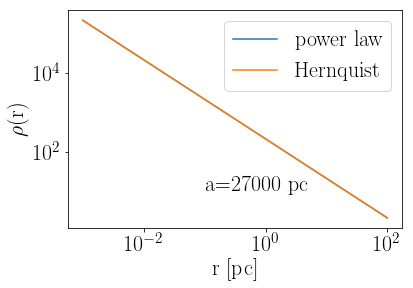

In [4]:
# r = sym.Symbol('r')
# a = sym.Symbol('a', nonnegative = True)
# asd = sym.integrate(r**2/((r/a)* (1+r/a)**3), (r, 0, np.infty))
# sym.simplify(asd)

r = np.logspace(-3,2,100)
a= 27000
# M = 1e12 #1024426239372.6198
rho_H0 = 0.00796477308477558 # M/(2*np.pi*a**3)
a2 = 27355.3624059166
M = 2*np.pi*a2**3 * rho_H0 * units.solMass

r1=0.01 # normalise simple power-law
r2 = 1e-50
rho_Hc = rho_H0/((r2/a2*(1+r2/a2)**3)) # find central density of real halo
rho_H0_high = rho_Hc * ((r2/a)*(1+r2/a)**3) # keeping central density same, changing a and rho_H0

rho_H = rho_H0_high / ((r/a)*(1+r/a)**3)
rho_0 = rho_H0_high
# r_0 = a
r_0 = r1 * rho_H0_high/rho_0 / ((r1/a)*(1+r1/a)**3)

rho_pl = rho_0 * (r/r_0)**(-1)
plt.plot(r, rho_pl, label='power law')
plt.plot(r, rho_H, label='Hernquist')
plt.text(1e-1,10, 'a=%.f pc' %a)
plt.ylabel(r'$\rho$(r)')
plt.xlabel('r [pc]')
plt.xscale('log')
plt.yscale('log')
plt.legend()
print(rho_H0_high, r_0, rho_0)

In [15]:
# functions and parameters
c = const.c
G = const.G
M1 = 2e6* units.solMass # BH mass
Rs1 = (2*G*M1/c**2).to(units.parsec).value
G = G.to(units.pc**3/units.Msun/units.s**2)
# r = np.logspace(np.log10((4+1e-8)*Rs1), 1, 300)

# rsim = np.loadtxt('DC_Simulation/rbin_100000')
# r = rsim[:,0]
r = np.logspace(np.log10(4.00001*Rs1), 3, 100)
# r = np.logspace(np.log10(1), 4, 50)



def pars(r, gamma, r_0, rho_0, M=M1, Rs=Rs1):
    
    r_0 = r_0 *units.parsec
    rho_0 = rho_0 *units.solMass/units.parsec**3
    
    # parameters
    lamda = (2/(4-gamma))**(1/(2-gamma)) * ((2-gamma)/(4-gamma))**(1/2)
    b = np.pi*(2-gamma) /sps.beta(1/(2-gamma), 3/2)
    beta = (6-gamma)/(2*(2-gamma))
    k = (3-gamma)/(gamma-4)
    kappa = (b*lamda-1)/(b*lamda)
    gamma_sp = (9-2*gamma)/(4-gamma)
    
    phi = 4*np.pi*G*r_0**2*rho_0/((3-gamma)*(2-gamma))
    
#     A1 = (b*phi**(1/(2-gamma)) / (2*r_0**2)**0.5) ** (-(6-gamma)/(4-gamma))
#     A2 = rho_0/(2*np.pi*phi)**(3/2) * sps.gamma(beta)/sps.gamma(beta-3/2) * phi**beta
    A1 = (phi * (b/(2*r_0**2*phi)**0.5)**(2*(2-gamma)/(4-gamma))) ** (-beta)
    A2 = rho_0/(2*np.pi*phi)**(3/2) * sps.gamma(beta)/sps.gamma(beta-3/2) * phi**beta
    Anew = 4*np.pi * A1*A2 * (G*M)**((3-gamma)/(4-gamma))

#     A = (M**(3-gamma) * rho_0 * r_0**gamma)**(1/(4-gamma))
#     B = 4*np.pi*1/((2*np.pi)**(3/2)) * (b/np.sqrt(2))**(-(6-gamma)/(4-gamma)) * sps.gamma(beta)/sps.gamma(beta-3/2) * (4*np.pi/((3-gamma)*(2-gamma)))**k
#     Anew = A*B
    return Anew, gamma_sp
    
def g(r, gamma, M=M1, Rs=Rs1):
    lamda = (2/(4-gamma))**(1/(2-gamma)) * ((2-gamma)/(4-gamma))**(1/2)
    b = np.pi*(2-gamma) /sps.beta(1/(2-gamma), 3/2)
    kappa = (b*lamda-1)/(b*lamda)

    # numerical integration
    integ_arr = []
    err = []
#     func = lambda y, x: y * (-kappa*y + 1/((-2*x)**(1/2)) )**((gamma-6)/(4-gamma)) / (2*(x + 1 - (y**2)/2))**(1/2)
    for ri in r:
#         num_integ = dblquad(func, -(1-4*Rs/ri), 0, 2*(2*Rs/ri)**0.5, lambda x: (2 * (x+1))**0.5 )
#         integ_arr.append(num_integ[0])
#         err.append(num_integ[1]) 
        
        def x_integ(x):
            def y_integ(x,y):
                return y * ( -kappa*y + 1/((-2*x)**(1/2)) )**((gamma-6)/(4-gamma)) / (2*(x + 1 - (y**2)/2))**(1/2)
            integ1 = quad(lambda y: y_integ(x,y),2*(2*Rs/ri)**0.5, (2 * (x+1))**0.5)
            return integ1[0]
        
        integ2 = quad(x_integ, -(1-4*Rs/ri), 0)   
        integ_arr.append(integ2[0])
        err.append(integ2[1]) 
            
    return integ_arr, err

def rho_prime(a, integ, r, gam_sp):
    return (a*integ*(r*units.parsec)**(-gam_sp)).value

t_bh = 1e10 *units.year # age of the BH
sigmav = 3e-26 *units.cm**3/units.s # WIMP annihilation cross-section
m = (100 *units.GeV/c**2).to(units.solMass) # DM particle mass
rho_core = (m/(sigmav*t_bh)).to(units.solMass/units.parsec**3).value

def rho_sp(rho_pr, rho_core=rho_core):
    return rho_pr*rho_core/(rho_pr+rho_core)

def rho0(r_0, gamma):
    return (1-gamma/3)*0.0062*(8500/r_0)**gamma

def r_cut(r, rho_sp, rho_core=rho_core): # radius where rho_sp = rho_core
    return r[rho_sp==rho_sp[(rho_sp>0.7*rho_core) & (rho_sp<1.5*rho_core) & (r>1e-5)]]

In [16]:
# integ1, err1 = g(r, 0.01)
# integ2, err2 = g(r, 0.4)
integ3, err3 = g(r, 1)
# integ4, err4 = g(r, 1.8)

In [17]:
D = 8500 # Sun distance from centre
a1, gam_sp1 = pars(r, 0.01, D, rho0(D, 0.01))
a2, gam_sp2 = pars(r, 0.1, D, rho0(D, 0.1))
a3, gam_sp3 = pars(r, 1, D, rho0(D, 1))
a4, gam_sp4 = pars(r, 1.6, D, rho0(D, 1.6))

r_scale = r_0
rho_scale = rho_0
anew, gam_spnew = pars(r, 1, r_scale, rho_scale) # to compare with Hernquist

Ah = 4*np.pi* M / (2**0.5 * (2*np.pi)**3*(27355*units.parsec)**(3/2))  *3*np.pi/2\
    *(2*(2*np.pi**2*(M1/M)**2)**(1/3) /5**(2/3))**(-5/2)* (27355*units.parsec)**(5/6)
Ah

<Quantity 1.34442735e+17 solMass / pc(2/3)>

[1.44809933 2.29365059]


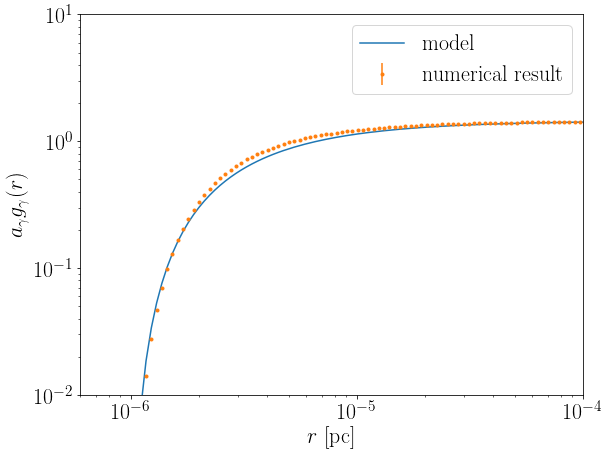

In [64]:
def model(x, *par, Rs_m=Rs1):
    return par[0]*(1-4*Rs_m/x)**par[1]

xval = r
yval = integ3
params, cov = spopt.curve_fit(model, xval, yval, p0=[1, 3], sigma=err3)
print(params)
yerr =(err3)
yy=(integ3)
a_gam = 0.14
gam = 0.4

plt.figure(figsize=(9,7))
plt.plot(r, model(r,*params), label=r'model')
# plt.plot(r, a_gam**((gam-3)**2/(4-gam))* (1-4*Rs1/r)**3, label='Gondolo & Silk')
#plt.plot(r, a1*b1*integ1*r**(-gam_sp1))
plt.errorbar(r, yy, yerr=yerr, fmt=".", label=r'numerical result')
# plt.plot(r, a1*params[0]*r**(-gam_sp1), label='without g(r)')
plt.legend()
plt.xlabel('$r \ [\mathrm{pc}]$')
plt.ylabel('${a}_{\gamma}  g_{\gamma}(r)$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 10)
plt.xlim(6e-7,1e-4)
plt.savefig('GS_plots/num_result', dpi=400)
plt.show()

In [10]:
# rho_comp = []

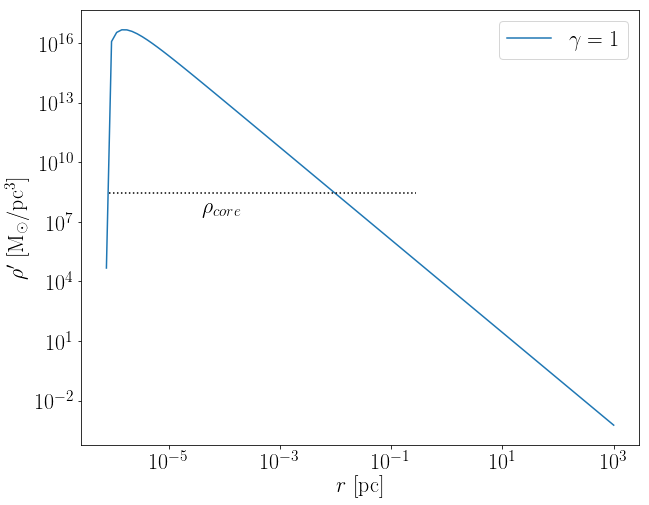

In [18]:
# rho_sp1 = (rho_prime(a1,integ1,r,gam_sp1))
# rho_sp2 = (rho_prime(a2,integ2,r,gam_sp2))
rho_sp3 = (rho_prime(anew,integ3,r,gam_spnew))
# rho_sph = (rho_prime(Ah,integh,r,gam_spnew))

# rho_sp4 = (rho_prime(a4,integ4,r,gam_sp4))
# rho_comp.append(rho_sp3)
# rho_sp1 = np.insert(rho_sp1,0,0)
# rho_sp2 = np.insert(rho_sp2,0,0)
# rho_sp3 = np.insert(rho_sp3,0,0)
# rho_sp4 = np.insert(rho_sp4,0,0)
# r2 = np.insert(r,0,4*Rs1)

plt.figure(figsize=(10,8))
# plt.plot(r, rho_sp1, label='$\gamma=0.01$')
# plt.plot(r, rho_sp2, label='$\gamma=0.1$')
plt.plot(r, rho_sp3, label=r'$\gamma=1$')
# plt.plot(r, rho_sph, label=r'$\gamma=1$')

# plt.plot(r, rho_sp4, label='$\gamma=1.8$')

# plt.plot(r, rho_comp[8], label='γ=1')

plt.axhline(rho_core, 0.05, 0.6, linestyle=':', color='black')
plt.text(4e-5,2e7, r'$\rho_{core}$')

plt.legend()
plt.xlabel(r'$r \ [\mathrm{pc}]$')
plt.ylabel(r'$\rho^\prime$ [M$_\odot$/pc$^3$]')
plt.xscale('log')
plt.yscale('log')
# plt.savefig('GS_plots/GS_spike', dpi=400)
plt.show()

In [16]:
# np.savetxt('rho_sp001', rho_sp1)
# np.savetxt('rho_sp01', rho_sp2)
np.savetxt('rho_sp1 compare with Hernq_a1', rho_sp3)
# np.savetxt('rho_sp16', rho_sp4)

In [9]:
def r_h(gamma, M_bh, rho_0, r_0):
    return r_0* ((3-gamma)/(2*np.pi) * M_bh/(rho_0*r_0**3)) ** (1/(3-gamma))

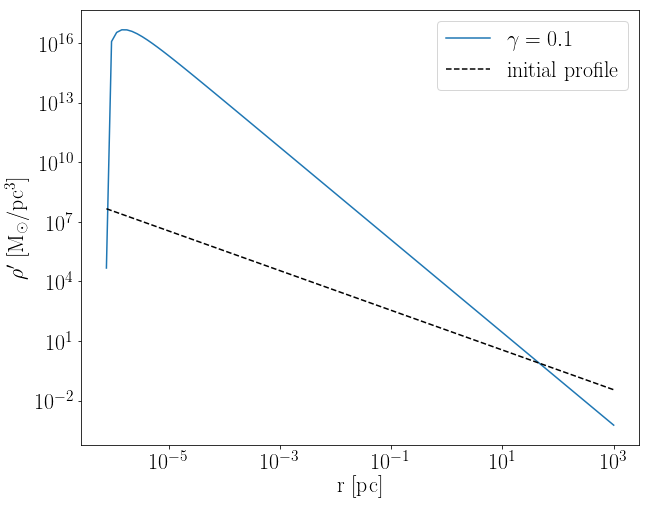

In [19]:

r_h2 = r_h(1, M1, rho0(0.1,1), 0.1)
plt.figure(figsize=(10,8))

plt.plot(r, rho_sp3, label=r'$\gamma=0.1$')
# plt.axhline(rho_core, 0.05, 0.35, linestyle=':', color='black')
# plt.text(1e-4,2e7, r'$\rho_{core}$')
rho_i = rho0(0.1, 1)*(0.1/r)**1
plt.plot(r, rho_i, color='black', linestyle='--', label='initial profile')
# plt.text(1, 1.6e-4, '$r_h=$ %.f pc' %r_h2.value)

plt.legend()
plt.xlabel('r [pc]')
plt.ylabel(r'$\rho^\prime$ [M$_\odot$/pc$^3$]')
plt.xscale('log')
plt.yscale('log')

plt.show()

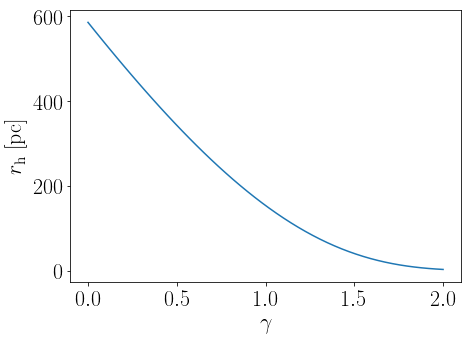

In [7]:
# r_h vs γ
M = M1.value
gam_arr = np.linspace(0,2, 50)
r_h_arr = r_h(gam_arr, M, rho0(0.1,gam_arr), 0.1)

plt.figure(figsize=(7,5))
plt.plot(gam_arr, r_h_arr)
plt.xlabel(r'$\gamma$')
plt.ylabel('$r_\mathrm{h}$ [pc]')
plt.savefig('GS_plots/r_h', dpi=350)

/home/jagoras/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


[ 0.10937993 -0.05        0.24626424  0.1002414 ]


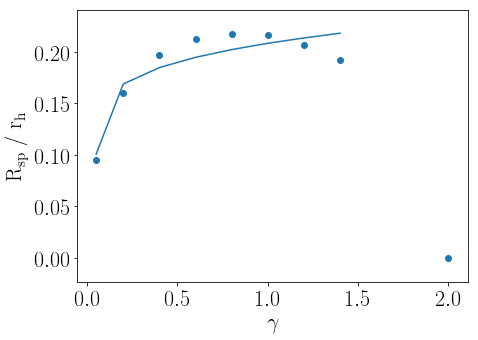

In [60]:
def rmodel(x, *par):
    return par[0]*(x+par[1])**par[2] + par[3]
# r_h vs R_sp
R_sp = np.zeros(9)
gam_arr2 = np.array([0.05, 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 2])
a_g = np.array([0.0733, 0.12, 0.14, 0.142, 0.135, 0.122, 0.103, 0.0818, 0.0177])
R_sp[:-1] = a_g[:-1]*0.1*(M/(rho0(0.1,gam_arr2)[:-1]*0.1**3))**(1/(3-gam_arr2[:-1]))
r_h_arr2 = r_h(gam_arr2, M, rho0(0.1,gam_arr2), 0.1)

rpars, rcov = spopt.curve_fit(rmodel, gam_arr2[:-1], (R_sp/r_h_arr2)[:-1], p0=[0.1085, 0.05, 0.2216339, 0.1013262])
print(rpars)

# plt.rcParams.update({'figure.autolayout': True})
plt.figure(figsize=(7,5))
plt.scatter(gam_arr2, R_sp/r_h_arr2)
plt.plot(gam_arr2[:-1], rmodel(gam_arr2[:-1], *rpars))
plt.xlabel(r'$\gamma$')
plt.ylabel('R$_{\mathrm{sp}}$ / r$_\mathrm{h}$')
plt.savefig('GS_plots/r_h-R_sp')
plt.show()

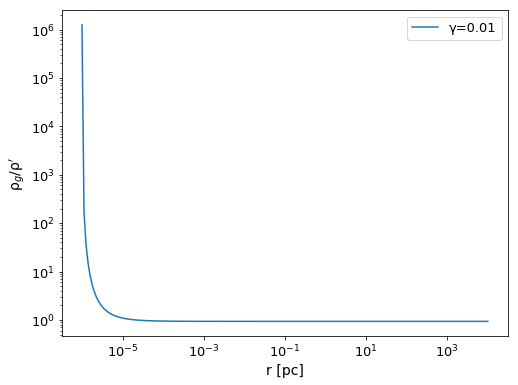

In [18]:
rho_g = (rho_prime(a1,params[0],r,gam_sp1))
plt.figure(figsize=(8,6))
# plt.plot(r, rho_sp1, label='γ=0.01')
plt.plot(r, rho_g/rho_sp1, label='γ=0.01')
plt.legend()
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('ρ$_g$/ρ$^{\prime}$', fontsize=14)
plt.xscale('log')
plt.yscale('log')

[1.38851144 2.00933211]


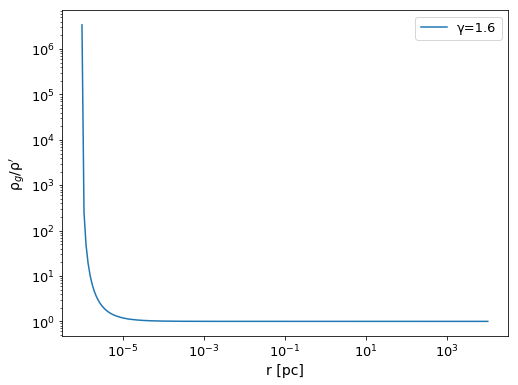

In [19]:
params2, cov = spopt.curve_fit(model, r, integ4, p0=[1, 3])
print(params2)

rho_g = (rho_prime(a4,params2[0],r,gam_sp4))
plt.figure(figsize=(8,6))
# plt.plot(r, rho_sp4, label='γ=1.6')
plt.plot(r, rho_g/rho_sp4, label='γ=1.6')
plt.legend()
plt.xlabel('r [pc]', fontsize=14)
plt.ylabel('ρ$_g$/ρ$^{\prime}$', fontsize=14)
plt.xscale('log')
plt.yscale('log')

In [104]:
# Comparing with Gondolo and Silk
gam_1 = 0.2
integ_c, err_c = g(r, gam_1)
integ_c2, err_c2 = g(r, 1.4)

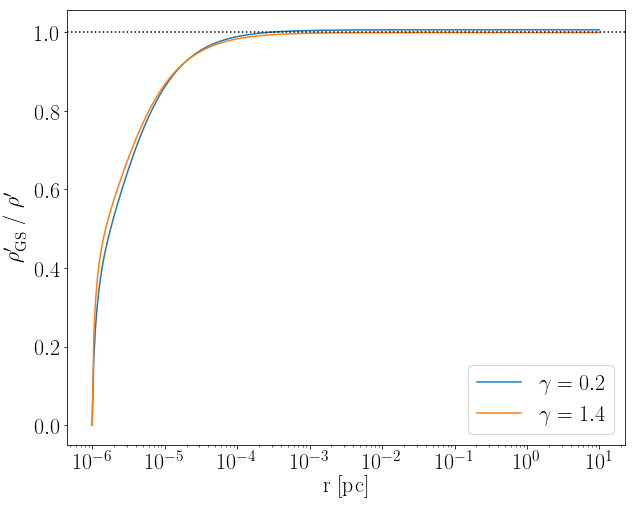

In [108]:
a_c, gam_spc = pars(r, gam_1, 0.1, 1e9)
a_c2, gam_spc2 = pars(r, 1.4, 0.1, 1e9)

# spike parameters
r_0 = 0.1 *units.parsec
rho_0 = 1e9 *units.solMass/units.parsec**3

def spike_profile(gam_1, a, r_0=r_0, rho_0=rho_0, r=r):
    gam_sp = (9-2*gam_1)/(4-gam_1)
    R_sp = a*r_0*(M1/(rho_0*r_0**3))**(1/(3-gam_1))
    rho_R = rho_0*(R_sp/r_0)**(-gam_1)
    g_r = (1-4*Rs1/r)**3
    
    return g_r*rho_R*(R_sp/r)**gam_sp, R_sp, rho_R

# gamma ray flux
def flux(gam, a, rho_sp, sigmav=sigmav.to(units.pc**3/units.s), m=m):
    gam_sp = (9-2*gam_1)/(4-gam_1)
    R_sp = spike_profile(gam, a)[1]
    rho_R = spike_profile(gam, a)[2]
    D = 1e3
    return rho_R**2 / (4*gam_sp-6) * sigmav/m**2 * R_sp**3/D**2 * (r_cut(r, rho_sp)/R_sp)**(-2*gam_sp+3)

gond1 = spike_profile(0.2, 0.12)[0]
gond2 = spike_profile(1.4, 0.0818)[0]

rho_me = rho_prime(a_c,integ_c,r,gam_spc)
rho_me2 = rho_prime(a_c2,integ_c2,r,gam_spc2)

plt.figure(figsize=(10,8))
# plt.plot(r, rho_prime(a_c,b_c,integ_c,r,gam_spc), label='me')
plt.plot(r, gond1/rho_me, label='$\gamma = 0.2$')
# plt.plot(r, rho_me)
plt.plot(r, gond2/rho_me2, label='$\gamma = 1.4$')

# plt.plot(r, rho_prime(a_c,b_c,integ_c,r,gam_spc), label='me')
# plt.plot(r, 1e9*(r/0.1)**(-0.05), label='ρ')
plt.xlabel('r [pc]')
plt.ylabel(r'$\rho^\prime_\mathrm{GS}$ / $\rho^\prime$')
# plt.text(R_sp.value, 2e9, '_R$_{sp}$', fontsize=12)
plt.axhline(1., linestyle=':', color='k')
plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.savefig('GS_plots/GS_compare', dpi=400)
plt.show()

# Distribution function

<Quantity 1.04980928e+29 s3 solMass / pc6>

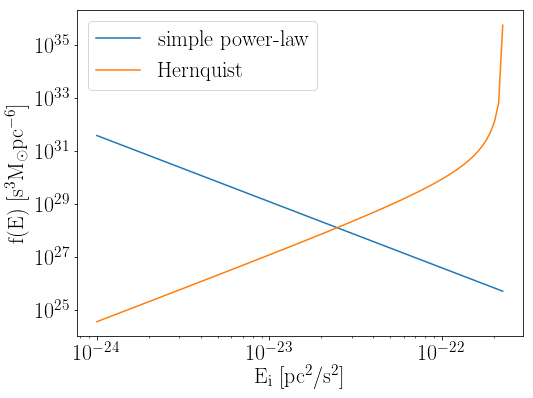

In [61]:
# distribution function from GS
gamma = 1
G = G.to(units.pc**3/units.solMass/units.s**2)
E = np.logspace(-24,np.log10(2.25e-22), 100)
r_scale = 20e3 *units.parsec
rho_0 = 1e10*units.solMass/(2*np.pi*r_scale**3)
phi = 4*np.pi*G*r_scale**2*rho_0/((3-gamma)*(2-gamma))
beta = (6-gamma)/(2*(2-gamma))
f = rho_0/(2*np.pi*phi)**(3/2) * sps.gamma(beta)/sps.gamma(beta-3/2) * (phi/E)**beta

# Hernq. distribution function
M_h = 1e12 *units.solMass
eps = r_scale.value/(G*M_h).value * E
A_H = M_h/(2**0.5 * (2*np.pi)**3 * (G*M_h*r_scale)**(3/2))
f_H = A_H * eps**0.5/(1-eps)**2 * ((1-2*eps)*(8*eps**2-8*eps-3) + 3*np.arcsin(eps**0.5)/np.sqrt(eps*(1-eps)))

plt.figure(figsize=(8,6))
plt.plot(E, f, label='simple power-law')
plt.plot(E, f_H, label='Hernquist')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('f(E) [s$^3$M$_\odot$pc$^{-6}$]')
plt.xlabel('E$_\mathrm{i}$ [pc$^2$/s$^2$]')
plt.legend()
A_H
# f[1]
A_H

# Energies

999978.455653099
2782523.4640704854
7742576.878386228
21544246.900318816


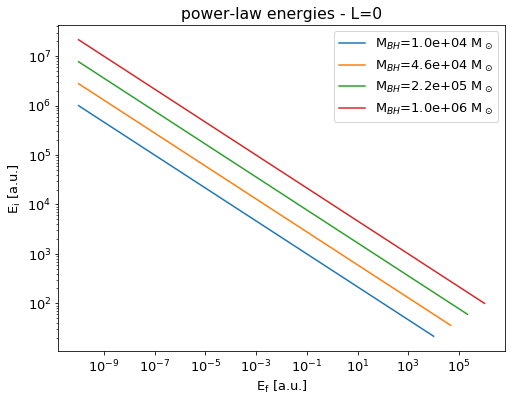

In [4]:
m_arr = np.logspace(4, 6, 4)
plt.figure(figsize=(8,6))
plt.title('power-law energies - L=0')
for m in m_arr:
    Ef = np.logspace(-10,np.log10(m),100)
    Ei = m**(2/3)*Ef**(-1/3)
    plt.plot(Ef, Ei, label='M$_{BH}$=%.1e M$_\odot$' %m)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('E$_\mathrm{f}$ [a.u.]')
    plt.ylabel('E$_\mathrm{i}$ [a.u.]')
    print(max(Ei)-min(Ei))
    
plt.legend()

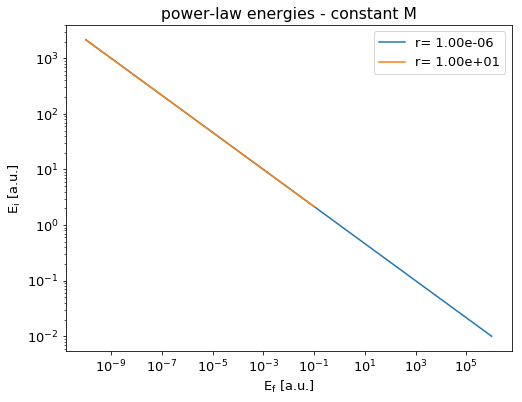

In [5]:
m=1
r_arr = np.logspace(-6, 1, 2)
plt.figure(figsize=(8,6))
plt.title('power-law energies - constant M')
for r in r_arr:
    Ef = np.logspace(-10,np.log10(1/r),100)
    Ei = m**(2/3)*Ef**(-1/3)
    plt.plot(Ef, Ei, label='r= %.2e' %r)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('E$_\mathrm{f}$ [a.u.]')
    plt.ylabel('E$_\mathrm{i}$ [a.u.]')
    
plt.legend()

In [87]:
flux(0.1,0.07, rho_sp1)

<Quantity [5.15030354e+36] pc(3/2) / s>

In [3]:
# np.array(rho_comp).shape
# rho_comp_re = np.array(rho_comp)
# rho_comp_re = np.reshape(rho_comp_re, (3,3,100))